In [1]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 16.6MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=5367cbe2723b0e1d311d827aa52d3c0bbf1f85a7570e26409e50196dbb637414
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=eda74a87d4a4041d2a21dcb3ae4266a3be726159da18ee9bd7859e8d73dead7d
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks
 abcnews-date-text.csv
 ab_data.csv
'A B Test.ipynb'
 AirPassengers.csv
'A method to categorical variable in flight delay datasets.ipynb'
'ARIMA Forecasting.ipynb'
 assignment0.ipynb
'assignment2_(release).ipynb'
 assignment2_sol.ipynb
 Automotive_5.json
'Building a Simple Chatbot.ipynb'
 chatbot.txt
'Classifying Tweets for Sentiment Analysis.ipynb'
'Concrete Compressive Strength Prediction.ipynb'
'Copy of Lec

In [8]:
import nltk
# import FreqDist 
nltk.download('stopwords') # run this one time
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import numpy as np 
import re 
import spacy 
import gensim 
from gensim import corpora 
# libraries for visualization 
import pyLDAvis 
import pyLDAvis.gensim 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
df = pd.read_json('Automotive_5.json', lines=True) 
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


- reviewerID — ID of the reviewer
- asin — ID of the product
- reviewerName — name of the reviewer
- helpful — helpfulness rating of the review, e.g. 2/3
- reviewText — text of the review
- overall — rating of the product
- summary — summary of the review
- unixReviewTime — time of the review (unix time)
- reviewTime — time of the review (raw)


# Data Preprocessing

In [0]:
# function to plot most frequent terms 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  
  fdist = FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()),   
             'count':list(fdist.values())}) 
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms)      
  plt.figure(figsize=(20,5)) 
  ax = sns.barplot(data=d, x= "word", y = "count") 
  ax.set(ylabel = 'Count') 
  plt.show()

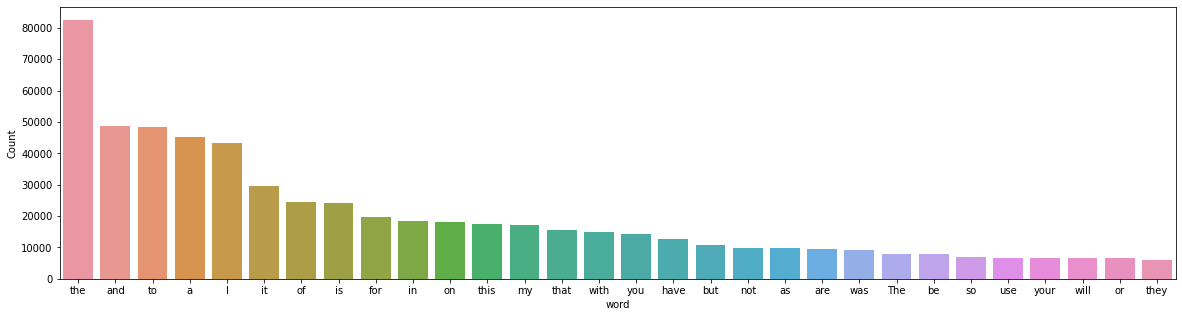

In [11]:
freq_words(df['reviewText'])

In [0]:
# remove unwanted characters, numbers and symbols 
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')
# function to remove stopwords 
def remove_stopwords(rev):     
  rev_new = " ".join([i for i in rev if i not in stop_words])      
  return rev_new 
# remove short words (length < 3) 
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for 
                   w in x.split() if len(w)>2])) 
# remove stopwords from the text 
reviews = [remove_stopwords(r.split()) for r in df['reviewText']] 
# make entire text lowercase 
reviews = [r.lower() for r in reviews]

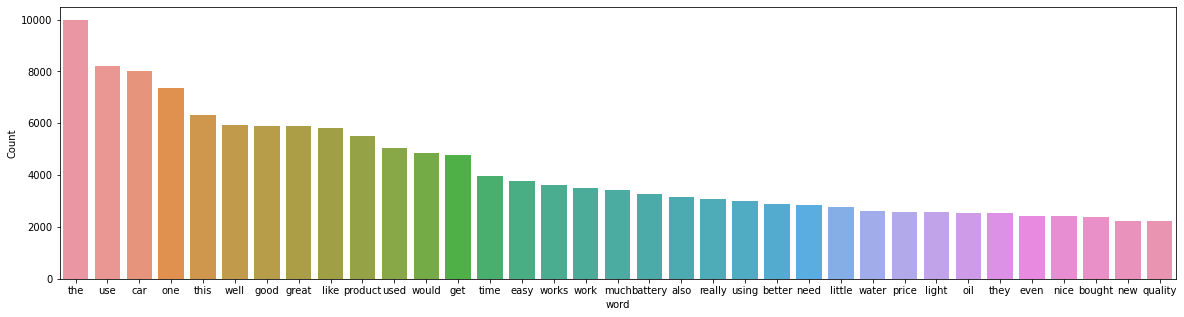

In [14]:
freq_words(reviews, 35)

We can see some improvement here. Terms like ‘battery’, ‘price’, ‘product’, ‘oil’ have come up which are quite relevant for the Automotive category. However, we still have neutral terms like ‘the’, ‘this’, ‘much’, ‘they’ which are not that relevant.

In [15]:
!python -m spacy download en #one time run
nlp = spacy.load('en', disable=['parser', 'ner']) 
def lemmatization(texts, tags=['NOUN', 'ADJ']): 
       output = []        
       for sent in texts:              
             doc = nlp(" ".join(sent))                             
             output.append([token.lemma_ for token in doc if 
             token.pos_ in tags])        
       return output

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [16]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [17]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'knock', 'shop', 'harbor', 'freight', 'buck']


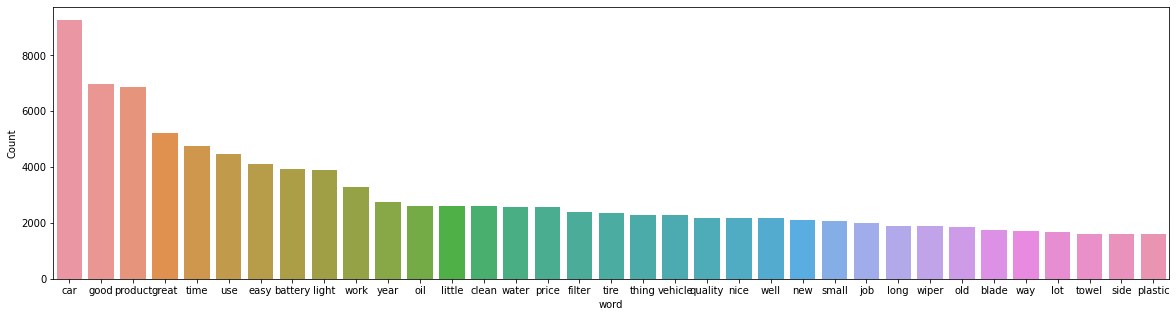

In [18]:
reviews_3 = []
for i in range(len(reviews_2)):
  reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.


# Building an LDA model

In [0]:
dictionary = corpora.Dictionary(reviews_2)

In [20]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
# Creating the object for LDA model using gensim library 
LDA = gensim.models.ldamodel.LdaModel 
# Build LDA model 
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,                                     
                num_topics=7, random_state=100, chunksize=1000,                                     
                passes=50)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

In [21]:
lda_model.print_topics()

[(0,
  '0.063*"light" + 0.024*"bulb" + 0.019*"bright" + 0.013*"engine" + 0.011*"code" + 0.011*"car" + 0.011*"tank" + 0.009*"plug" + 0.009*"white" + 0.009*"tape"'),
 (1,
  '0.057*"water" + 0.052*"towel" + 0.032*"clean" + 0.021*"car" + 0.018*"dry" + 0.016*"job" + 0.016*"soft" + 0.015*"wheel" + 0.015*"use" + 0.015*"good"'),
 (2,
  '0.056*"tire" + 0.033*"hose" + 0.027*"pressure" + 0.021*"gauge" + 0.019*"air" + 0.016*"mat" + 0.013*"port" + 0.012*"valve" + 0.011*"glove" + 0.010*"tool"'),
 (3,
  '0.016*"wiper" + 0.016*"blade" + 0.015*"easy" + 0.013*"good" + 0.011*"great" + 0.010*"side" + 0.009*"work" + 0.009*"time" + 0.009*"plastic" + 0.008*"little"'),
 (4,
  '0.027*"leather" + 0.026*"good" + 0.026*"oil" + 0.024*"price" + 0.022*"product" + 0.018*"filter" + 0.016*"quality" + 0.014*"great" + 0.013*"car" + 0.011*"year"'),
 (5,
  '0.047*"battery" + 0.027*"car" + 0.023*"power" + 0.018*"unit" + 0.018*"device" + 0.013*"light" + 0.013*"charger" + 0.012*"use" + 0.012*"phone" + 0.011*"charge"'),
 (6,
 

The fourth topic Topic 3 has terms like ‘towel’, ‘clean’, ‘wax’, ‘water’, indicating that the topic is very much related to car-wash. Similarly, Topic 6 seems to be about the overall value of the product as it has terms like ‘price’, ‘quality’, and ‘worth’.

# Topics Visualization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [22]:
# Visualize the topics 
pyLDAvis.enable_notebook() 
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix,  
                              dictionary) 
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.027294  0.013031       1        1  26.364767
6     -0.118532 -0.052255       2        1  18.705748
4     -0.101830  0.071299       3        1  14.419895
5     -0.052398  0.107846       4        1  13.011143
0     -0.029631  0.197291       5        1  11.517979
1     -0.064696 -0.317832       6        1   8.849909
2      0.394379 -0.019381       7        1   7.130564, topic_info=         Term         Freq        Total Category  logprob  loglift
135     light  4627.000000  4627.000000  Default  30.0000  30.0000
38    battery  3000.000000  3000.000000  Default  29.0000  29.0000
479     water  2488.000000  2488.000000  Default  28.0000  28.0000
482     towel  2285.000000  2285.000000  Default  27.0000  27.0000
307      tire  1955.000000  1955.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
206      case   176.246445   743.367615   Topic7  -5.2935   1.2015
617      heat   148.631195   313.651062   Topic7  -5.4639   1.8940
140       low   165.304977   897.328613   Topic7  -5.3576   0.9491
1434      kit   153.499283  1256.090820   Topic7  -5.4317   0.5387
105      easy   147.065216  3688.354736   Topic7  -5.4745  -0.5813

[428 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1177      6  0.995923  absorbent
1047      4  0.997321   accurate
2498      1  0.361835    adapter
2498      4  0.637811    adapter
1890      5  0.908329   adhesive
...     ...       ...        ...
248       2  0.315585       year
248       3  0.335335       year
248       4  0.136571       year
248       5  0.054208       year
5665      6  0.987479      zwipe

[686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 6, 1, 2, 3])

# Other Methods to Leverage Online Reviews
Apart from topic modeling, there are many other NLP methods as well which are used for analyzing and understanding online reviews. Some of them are listed below:
1. <b> Text Summarization:</b> Summarize the reviews into a paragraph or a few bullet points.
2. <b> Entity Recognition:</b> Extract entities from the reviews and identify which products are most popular (or unpopular) among the consumers.
3. <b> Identify Emerging Trends:</b> Based on the timestamp of the reviews, new and emerging topics or entities can be identified. It would enable us to figure out which products are becoming popular and which are losing their grip on the market.
4. <b> Sentiment Analysis:</b> For retailers, understanding the sentiment of the reviews can be helpful in improving their products and services.